In [78]:
#!pip install gravis numpy pandas matplotlib networkx joblib logging requests beautifulsoup4

In [79]:
import logging as log
log.basicConfig(level=log.INFO)

In [80]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

This is a test implementation of the PageRank algorithm in Python.

## Build Site Graph
We need a markov chain graph of N nodes with the requirements:
1. Disregard duplicate links
2. Disregard links to external sites
3. Disregard links to the same page
4. No dangling nodes (nodes with no links)

In [81]:
root = "https://www.ie.edu/"

In [82]:
run = False
if run:
    graph = {
        root: []
    }
    # DFS to build the graph
    visited = set()
    stack = [root]
    while stack and len([node for node in graph.keys() if root in node and len(graph[node]) > 5]) < 30:
        current = stack.pop(0)
        if 'mailto' in current:
            continue
        if current in visited:
            continue
        visited.add(current)
        log.info(f"Visiting {current}")
        try:
            response = requests.get(current)
        except:
            continue
        soup = BeautifulSoup(response.text, "html.parser")
        for link in soup.find_all("a"):
            href = link.get("href")
            if href is None:
                continue
            if href == current:
                continue
            if 'ie.edu' not in href:
                continue
            graph.setdefault(current, []).append(href)
            if href not in graph:
                graph[href] = [] 
                stack.append(href)
    # save the graph
    with open("graph.pkl", "wb") as file:
        joblib.dump(graph, file)


In [83]:
import joblib
with open("graph.pkl", "rb") as file:
    graph = joblib.load(file)

Now we need to _clean_ the graph by removing dangling nodes and external links.

In [84]:
for node in list(graph.keys()):
    graph[node] = [link for link in graph[node] if link in graph.keys()]
# Remove nodes with no links
for node in list(graph.keys()):
    if not graph[node]:
        del graph[node]
# Remove external links
for node in list(graph.keys()):
    graph[node] = [link for link in graph[node] if link.startswith(root) and link in graph]
# link from node to itself
for node in list(graph.keys()):
    graph[node] = [link for link in graph[node] if link != node]
# remove any that have no outgoing links
for node in list(graph.keys()):
    if len(graph[node]) == 0:
        del graph[node]
# no duplicate links
for node in list(graph.keys()):
    graph[node] = list(set(graph[node]))

In [85]:
graph

{'https://www.ie.edu/': ['https://www.ie.edu/business-school/why-ie-business-school/international-advisory-board/',
  'https://www.ie.edu/chat-students-staff/',
  'https://www.ie.edu/es/',
  'https://www.ie.edu/research/',
  'https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/',
  'https://www.ie.edu/sustainability/',
  'https://www.ie.edu/alumni-stories/manuel-atienza/',
  'https://www.ie.edu/our-purpose/',
  'https://www.ie.edu/student-services/',
  'https://www.ie.edu/registrar-office/',
  'https://www.ie.edu/alumni-stories/isabella-miller/',
  'https://www.ie.edu/financial-aid/',
  'https://www.ie.edu/university/about/faculty/?',
  'https://www.ie.edu/insights/subjects/future-of-education/',
  'https://www.ie.edu/insights/videos/how-to-be-an-everyday-activist/',
  'https://www.ie.edu/admissions/',
  'https://www.ie.edu/podcasts/',
  'https://www.ie.edu/search-results/',
  'https://www.ie.edu/alumni/',
  'https://www.ie.edu/find-y

In [86]:
# any urls that have policy or legal or cookies in them
for node in list(graph.keys()):
    if 'policy' in node or 'legal' in node or 'cookie' in node:
        del graph[node]

We can now visualize the graph using the `networkx` library in connection to the `gravis` library.

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import gravis as gv

G = nx.DiGraph(graph)

fig=gv.d3(G, 
    graph_height=700,
    node_size_data_source="betweenness_centrality",
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,
    node_hover_neighborhood=True,
    show_node_label=False,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,
    edge_curvature=-0.5,
    links_force_distance=797,
    links_force_strength=1
  )
try:
    fig.export_png("graph1.png")
    fig.export_html("graph1.html")
except:
    pass

Here we can see a segment of our graph:
![graph](graph1.png)
As we can see, the graph is too large to visualize in its entirety in a single image. However we can see that it is highly interconnected.

In [88]:
# lets see how many nodes and edges we have
log.info(f"Nodes: {len(G.nodes)}")
log.info(f"Edges: {len(G.edges)}")

INFO:root:Nodes: 32
INFO:root:Edges: 285


## Mouse Click Model

In [89]:
counts = [1,10,100,1000,5000]
df = pd.DataFrame(columns=counts)

In [90]:
np.random.choice(G['https://www.ie.edu/'])

'https://www.ie.edu/university/about/faculty/?'

In [91]:
# remove any nodes that have no outgoing links
for node in list(G.nodes):
    if len(G[node]) == 0:
        G.remove_node(node)

In [92]:
for count in counts:
    visits = {node: 0 for node in G.nodes}
    current = root
    for _ in range(count):
        print(current)
        visits[current] += 1
        cn = np.random.choice(G[current])
        i = 10
        while len(G[cn]) == 0 and i > 0:
            print(G[current])
            cn = np.random.choice(G[current])
            i= i-1
        current = cn
    df[count] = pd.Series(visits)

https://www.ie.edu/
https://www.ie.edu/
https://www.ie.edu/business-school/why-ie-business-school/international-advisory-board/
https://www.ie.edu/corporate-relations/
https://www.ie.edu/insights/
https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/
https://www.ie.edu/insights/
https://www.ie.edu/corporate-relations/
https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/
https://www.ie.edu/insights/
https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/
https://www.ie.edu/
https://www.ie.edu/insights/
https://www.ie.edu/corporate-relations/
https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/
https://www.ie.edu/corporate-relations/
https://www.ie.edu/insights/videos/how-to-be-an-everyday-activist/
https://www.ie.edu/corporate-relations/
https://www.ie.edu/insights/
https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/
ht

In [93]:
df.sort_values(5000, ascending=False)

,1,10,100,1000,5000
https://www.ie.edu/insights/,0,3,14,139,732
https://www.ie.edu/corporate-relations/,0,2,7,132,624
https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/,0,1,8,98,553
https://www.ie.edu/,1,1,12,109,549
https://www.ie.edu/insights/videos/how-to-be-an-everyday-activist/,0,0,9,94,454
https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/,0,2,4,83,415
https://www.ie.edu/search-results/,0,0,8,60,245
https://www.ie.edu/insights/subjects/future-of-education/,0,0,3,37,213
https://www.ie.edu/our-purpose/,0,0,6,30,148
https://www.ie.edu/chat-students-staff/,0,0,1,18,108


In [94]:
simple_sv = df[5000].sort_values(ascending=False) / df[5000].sum(); simple_sv

https://www.ie.edu/insights/                                                                                0.1464
https://www.ie.edu/corporate-relations/                                                                     0.1248
https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/                                 0.1106
https://www.ie.edu/                                                                                         0.1098
https://www.ie.edu/insights/videos/how-to-be-an-everyday-activist/                                          0.0908
https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/    0.0830
https://www.ie.edu/search-results/                                                                          0.0490
https://www.ie.edu/insights/subjects/future-of-education/                                                   0.0426
https://www.ie.edu/our-purpose/                                                 

In [95]:
# export head of df to a latex table
df.head().to_latex("clicks_table.tex")

In [96]:
# top 3 pages
top3list = df.sort_values(5000, ascending=False).index[:3]; top3list

Index(['https://www.ie.edu/insights/',
       'https://www.ie.edu/corporate-relations/',
       'https://www.ie.edu/insights/articles/technologys-role-in-the-esg-evolution/'],
      dtype='object')

Our top 3 pages are now stored in `top3list`.
Lets plot a weighted graph of all the pages with the top 3 pages highlighted.

We can now build an adjacency matrix from the graph and calculate the PageRank.

In [97]:
adjacency = nx.to_numpy_array(G).astype('int')
pd.DataFrame(adjacency).to_latex("adjacency.tex")
# make diagonal 0s
adjacency

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

To further improve our adjecency list we need to normalize it and have each link be a probability.

In [98]:
# forgot to normalize the adjacency matrix to prov (each col sums to 1)
norm_adjacency = adjacency / np.sum(adjacency, axis=1)[:, None]
norm_adjacency = np.nan_to_num(norm_adjacency)
norm_adjacency

/tmp/ipykernel_160053/2053200751.py:2: RuntimeWarning: invalid value encountered in divide
  norm_adjacency = adjacency / np.sum(adjacency, axis=1)[:, None]


array([[0.        , 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.        , 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.        , 0.04166667, 0.04166667,
        0.04166667, 0.04166667],
       [0.07142857, 0.        , 0.        , 0.07142857, 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.08333333, 0.08333333, 0.        , 0.        , 0.08333333,
        0.08333333, 0.        , 0.        , 0.08333333, 0.        ,
        0.08333333, 0.        , 0.        , 0.08333333, 0.        ,
        0.        , 0.        , 0.08333333, 0.0833

In [99]:
# eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(norm_adjacency)
eigenvalues = np.real(eigenvalues).round(1)
# get vectort where eigenvalue is 1
eigenvector = eigenvectors[:, np.isclose(eigenvalues, 1)]
eigenvector = np.real(eigenvector) / np.sum(np.real(eigenvector))
eigenvector

array([[ 0.03757676],
       [ 0.03576106],
       [ 0.0365984 ],
       [ 0.03940423],
       [ 0.04254737],
       [ 0.03558335],
       [ 0.03558335],
       [ 0.03722517],
       [ 0.03576106],
       [ 0.03914308],
       [-0.        ],
       [ 0.03940423],
       [ 0.03623076],
       [ 0.04183363],
       [ 0.03576106],
       [ 0.03576106],
       [ 0.03825215],
       [ 0.04138326],
       [ 0.04187545],
       [ 0.04178099],
       [ 0.04169447],
       [ 0.04252045],
       [ 0.03825215],
       [ 0.03940423],
       [ 0.03940423],
       [ 0.03562903],
       [ 0.03562903]])

Another very important concept about this adjecency matrix is that a simple eigenvector compuation for $\lambda = 1$ will give us the PageRank vector.

## Simulation

In [100]:
# trim to 5x5 dataframe for latex
pd.DataFrame(norm_adjacency[:5, :5]).to_latex("norm_adjacency.tex")

To further deepen our understanding of how the vectors are working, we can look the PCA of the adjecency. This will allow us to see the 26 dimensional vectors in 3D space.

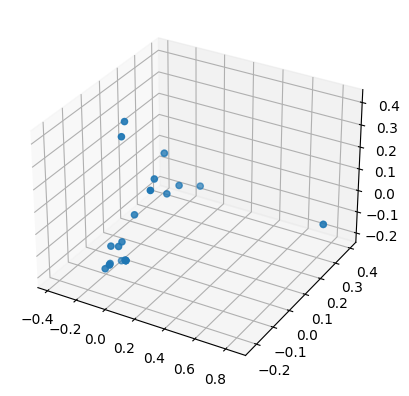

In [101]:
# lets visualize with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(norm_adjacency)
pca_adjacency = pca.transform(norm_adjacency)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_adjacency[:, 0], pca_adjacency[:, 1], pca_adjacency[:, 2])
plt.show()

Ok so now we can see how we have a distribution of the various nodes in 3D space. We can see that the nodes are not evenly distributed and that there are some nodes that are more central than others. Now we can actually tackle the PageRank algorithm.

$$
x^k = A * x^{k-1}
$$

Where $x^k$ is the PageRank vector at time $k$ and $A$ is the normalized adjacency matrix. We will use the value of $k=15$.

In [102]:
k = 1000
x_0 = np.zeros(len(G.nodes))
x_0[list(G.nodes).index(root)] = 1 # start at root
for _ in range(k):
    print(x_0)
    x_0 = np.dot(norm_adjacency, x_0)
x_k = x_0 / np.sum(x_0)
x_k

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0.         0.07142857 0.08333333 0.         0.         0.
 0.         0.05555556 0.07142857 0.         0.         0.
 0.06666667 0.2        0.07142857 0.07142857 1.         0.33333333
 0.16666667 0.2        0.25       0.         1.         0.
 0.         0.         0.        ]
[0.06838624 0.038322   0.1077381  0.1        0.20416667 0.04676435
 0.04676435 0.06494709 0.038322   0.01851852 0.         0.1
 0.03608466 0.12333333 0.038322   0.038322   0.         0.06666667
 0.16388889 0.14       0.09166667 0.21666667 0.         0.1
 0.1        0.04342404 0.04342404]
[0.08197258 0.06599508 0.08541174 0.08504884 0.12972222 0.06516174
 0.06516174 0.08386268 0.06599508 0.1052927  0.         0.08504884
 0.07618901 0.13362169 0.06599508 0.06599508 0.06838624 0.13196208
 0.11570326 0.12528836 0.13994378 0.11833333 0.06838624 0.08504884
 0.08504884 0.06384764 0.06384764]
[0.08781356 0.07921909 0.09326779 0.09939172 

array([0.03757676, 0.03576106, 0.0365984 , 0.03940423, 0.04254737,
       0.03558335, 0.03558335, 0.03722517, 0.03576106, 0.03914308,
       0.        , 0.03940423, 0.03623076, 0.04183363, 0.03576106,
       0.03576106, 0.03825215, 0.04138326, 0.04187545, 0.04178099,
       0.04169447, 0.04252045, 0.03825215, 0.03940423, 0.03940423,
       0.03562903, 0.03562903])

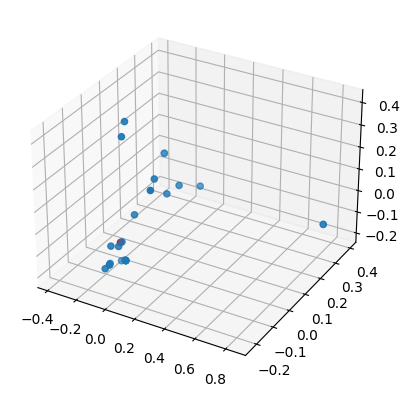

In [103]:
# lets see where our x_k is on the PCA plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_adjacency[:, 0], 
           pca_adjacency[:, 1], 
           pca_adjacency[:, 2])
xkpca = pca.transform(x_k.reshape(1, -1))
ax.scatter(xkpca[:, 0], 
           xkpca[:, 1], 
           xkpca[:, 2], 
           color="red")
plt.show()

In [104]:
# where might we end up? top 2:
top2 = np.argsort(x_k)[-2:]
top2 = [list(G.nodes)[i] for i in top2]; top2

['https://www.ie.edu/sustainability/',
 'https://www.ie.edu/corporate-relations/']

Here we can see the final PageRank vector in red. We started by taking the adjecency matrix and seeing the 26 dimensional vectors in 3D space. We then projected the PageRank vector onto this space. We can see that the PageRank vector is close to the center of the graph.

# Damping Factor

In [105]:
damping = 0.9
page = 'https://www.ie.edu/'
log.info(f"Starting at {page}")
x_0 = np.zeros(len(G.nodes))
x_0[list(G.nodes).index(page)] = 1
x_0
x_n = []
for _ in range(5):
    x_n.append(x_0)
    x_0 = damping * np.dot(norm_adjacency, x_0) + (1 - damping) / len(G.nodes)
    visiting_page = list(G.nodes)[np.argmax(x_0)]
    log.info(f"Visiting {visiting_page}")
x_n = x_n[-1] / np.sum(x_n[-1]); x_n

INFO:root:Starting at https://www.ie.edu/
INFO:root:Visiting https://events.ie.edu
INFO:root:Visiting https://www.ie.edu/sustainability/
INFO:root:Visiting https://www.ie.edu/insights/articles/not-all-stakeholders-are-created-equal-a-tribute-to-michael-jensen/
INFO:root:Visiting https://www.ie.edu/sustainability/
INFO:root:Visiting https://www.ie.edu/corporate-relations/


array([0.03570681, 0.03273788, 0.03741745, 0.03969367, 0.0495315 ,
       0.03267346, 0.03267346, 0.03585233, 0.03273788, 0.03751921,
       0.00188856, 0.03969367, 0.0333998 , 0.04613661, 0.03273788,
       0.03273788, 0.03386163, 0.04498461, 0.04788682, 0.04616014,
       0.04503938, 0.0509741 , 0.03386163, 0.03969367, 0.03969367,
       0.03235314, 0.03235314])

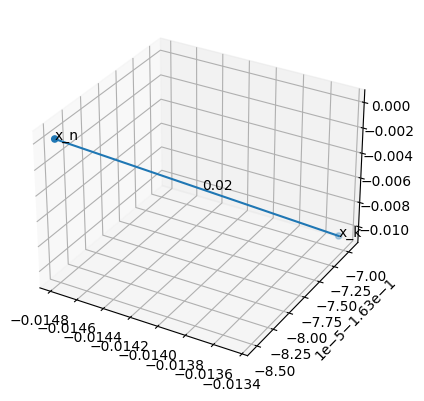

In [106]:
a,b = x_n, x_k
# PLOT pca of the 2
v = np.array([a, b])
pca_adjacency = pca.transform(v)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_adjacency[:, 0], pca_adjacency[:, 1], pca_adjacency[:, 2])
distance = np.linalg.norm(a - b); distance
# tell lable the distance
ax.text(pca_adjacency[0, 0], pca_adjacency[0, 1], pca_adjacency[0, 2], "x_n")
ax.text(pca_adjacency[1, 0], pca_adjacency[1, 1], pca_adjacency[1, 2], "x_k")
# label the distance
ax.text((pca_adjacency[0, 0] + pca_adjacency[1, 0]) / 2, 
        (pca_adjacency[0, 1] + pca_adjacency[1, 1]) / 2, 
        (pca_adjacency[0, 2] + pca_adjacency[1, 2]) / 2, 
        f"{distance:.2f}")
# draw a line between the two points
ax.plot(pca_adjacency[:, 0], pca_adjacency[:, 1], pca_adjacency[:, 2])
plt.show()